# Active Learning

### Hyperparams

In [1]:
TRAIN_VAL_SPLIT = 0.1
BATCH_SIZE = 32

EPOCHS_BASELINE = 3

EPOCHS_AL = 1
AL_SAMPLE_SIZE = 500
AL_ITERATIONS = 10
SAMPLING_METHOD = 1

### Imports

In [2]:
# General
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from time import time
import math
from scipy.stats import entropy

import tensorflow as tf

# CNNs
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D

# TensorBoard
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint

## Baseline CNN Method

### Full dataset

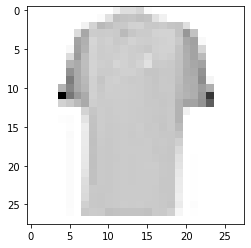

(60000, 28, 28)

In [7]:
(X_train_baseline, y_train_baseline), (X_test_baseline, y_test_baseline) = tf.keras.datasets.fashion_mnist.load_data()
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

X_train_baseline = tf.keras.utils.normalize(X_train_baseline, axis=1)
X_test_baseline = tf.keras.utils.normalize(X_test_baseline, axis=1)

plt.imshow(X_train_baseline[np.random.randint(0, X_train_baseline.shape[0])], cmap=plt.cm.binary)
plt.show()

X_train_baseline.shape

### CNN model

In [8]:
no_channels = 1
input_shape = (X_train_baseline.shape[1], X_train_baseline.shape[2], no_channels)

# sequential apif
# convolutional layers: specify no. conv filters (to give certain output shape), kernel dimensions
baseline_model = Sequential([
    Conv2D(64, (3, 3), input_shape=input_shape, activation="relu"),
    MaxPooling2D(pool_size=(2, 2)),

    Conv2D(64, (3, 3), activation="relu"),
    MaxPooling2D(pool_size=(2, 2)),

    Flatten(),
    Dense(64, activation="relu"),

    Dense(10, activation="softmax")
])

# compile model
baseline_model.compile(loss="sparse_categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

# fit model
baseline_history = baseline_model.fit(X_train_baseline, y_train_baseline, epochs=EPOCHS_BASELINE, batch_size=BATCH_SIZE, validation_split=TRAIN_VAL_SPLIT)

Epoch 1/3
1688/1688 [==============================] - 7s 4ms/step - loss: 0.5017 - accuracy: 0.8139 - val_loss: 0.3928 - val_accuracy: 0.8535
Epoch 2/3
1688/1688 [==============================] - 6s 3ms/step - loss: 0.3429 - accuracy: 0.8733 - val_loss: 0.3203 - val_accuracy: 0.8825
Epoch 3/3
1688/1688 [==============================] - 6s 3ms/step - loss: 0.2947 - accuracy: 0.8909 - val_loss: 0.2899 - val_accuracy: 0.8918


313/313 [==============================] - 1s 3ms/step - loss: 0.3189 - accuracy: 0.8838
loss = 0.3188593089580536
accuracy = 0.8838000297546387


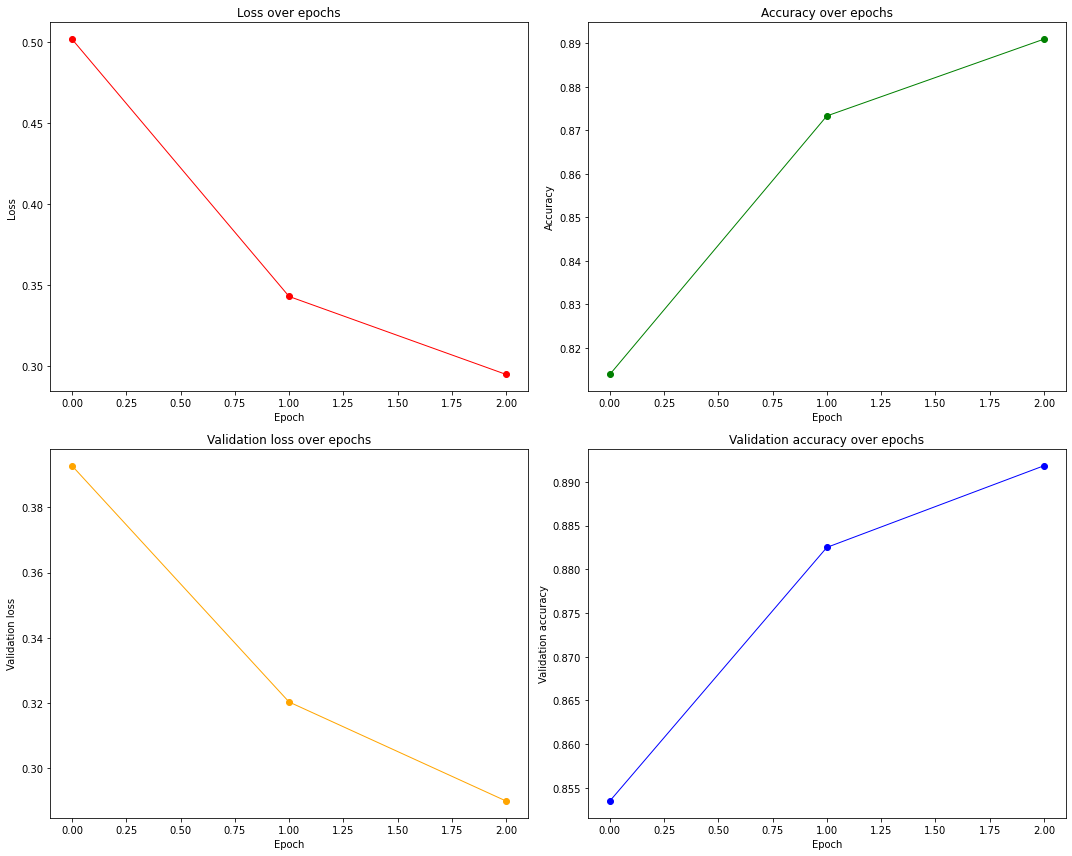

In [9]:
test_loss_baseline, test_acc_baseline = baseline_model.evaluate(X_test_baseline, y_test_baseline)
print(f"loss = {test_loss_baseline}")
print(f"accuracy = {test_acc_baseline}")

fig, ax = plt.subplots(2, 2, figsize=(15, 12))

baseline_loss = baseline_history.history['loss']
ax[0, 0].plot(baseline_loss, linewidth=1.0, color='red', marker='o')
ax[0, 0].set(title=f'Loss over epochs', xlabel='Epoch', ylabel='Loss')

baseline_accuracy = baseline_history.history['accuracy']
ax[0, 1].plot(baseline_accuracy, linewidth=1.0, color='green', marker='o')
ax[0, 1].set(title=f'Accuracy over epochs', xlabel='Epoch', ylabel='Accuracy')

baseline_valloss = baseline_history.history['val_loss']
ax[1, 0].plot(baseline_valloss, linewidth=1.0, color='orange', marker='o')
ax[1, 0].set(title=f'Validation loss over epochs', xlabel='Epoch', ylabel='Validation loss')

baseline_valacc = baseline_history.history['val_accuracy']
ax[1, 1].plot(baseline_valacc, linewidth=1.0, color='blue', marker='o')
ax[1, 1].set(title=f'Validation accuracy over epochs', xlabel='Epoch', ylabel='Validation accuracy')
    
plt.tight_layout()
plt.show()

## Active learning process

1. Gather full dataset.
2. Split full dataset into *training* and *testing* datasets.
3. Split training dataset into labelled *pool* (initially the *seed*) and unlabelled *validation* sets.
4. Initially train model over *seed*.
5. Use model to generate prediction probabilities over validation set.
6. Evaluate importance function over instances in the validation set.
7. Select the top $k$ most important instances, label, and move to the pool dataset.
8. Renormalise pool and retrain model.
9. Repeat for until max. epochs or accuracy goal is met.
10. Test final model on testing dataset.

### Class implementation of an active learner

In [3]:
class ActiveLearner:
    def __init__(self):
        # get train/test data
        (self.X_train, self.y_train), (self.X_test, self.y_test) = self.get_dataset()
        input_shape = (self.X_train.shape[1], self.X_train.shape[2], 1)

        self.X_pool, self.y_pool, self.X_val, self.y_val = None, None, None, None

        # define model
        self.model = Sequential([
            Conv2D(64, (3, 3), input_shape=input_shape, activation="relu"),
            MaxPooling2D(pool_size=(2, 2)),

            Conv2D(64, (3, 3), activation="relu"),
            MaxPooling2D(pool_size=(2, 2)),

            Flatten(),
            Dense(64, activation="relu"),

            Dense(10, activation="softmax")
        ])

        # compile model
        self.model.compile(loss="sparse_categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

        # metrics
        self.pool_sizes = []
        self.losses = []
        self.accuracies = []
        self.losses_val = []
        self.accuracies_val = []
        self.test_loss, self.test_acc = 0, 0

    def get_dataset(self):
        # 1. pull full dataset and 2. conduct train-test split
        class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
        (X_train, y_train), (X_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()

        # normalise datasets
        X_train = tf.keras.utils.normalize(X_train, axis=1)
        X_test = tf.keras.utils.normalize(X_test, axis=1)

        return (X_train, y_train), (X_test, y_test)

    def set_seed(self, k=AL_SAMPLE_SIZE):
        # 3. split into seed pool and validation sets
        self.X_pool = self.X_train[:k]
        self.y_pool = self.y_train[:k]
        self.X_val = self.X_train[k:]
        self.y_val = self.y_train[k:]

        return True

    def initial_training(self, e=EPOCHS_AL, bs=BATCH_SIZE, split=TRAIN_VAL_SPLIT):
        # 4. initially train model over seed pool
        print(f"Pool set: {self.X_pool.shape[0]}; Validation set: {self.X_val.shape[0]}")

        history = self.model.fit(self.X_pool, self.y_pool, epochs=e, batch_size=bs, validation_split=split)

        self.pool_sizes = [self.X_pool.shape[0]]
        self.losses = history.history['loss']
        self.accuracies = history.history['accuracy']
        self.losses_val = history.history['val_loss']
        self.accuracies_val = history.history['val_accuracy']
        
        return True

    def get_sample_indices(self, probabilities, version=SAMPLING_METHOD, k=AL_SAMPLE_SIZE):
        # retrieve new indices of instances to add to pool through importance sampling
        if version == 1:
            # 6. uncertainty sampling
            importance_scores = np.max(probabilities, axis=1)

            # 7. select k most important instances as those with the smallest prediction probability
            important_indices = np.argpartition(importance_scores, k)[:k]

        elif version == 2:
            # 6. entropy sampling
            importance_scores = entropy(probabilities, axis=1)

            # 7. select k most important instances as those with the largest entropy
            important_indices = np.argpartition(importance_scores, -k)[-k:]

        elif version == 3:
            # 6. margin sampling
            highest_two_probs = np.partition(probabilities, -2, axis=1)[:, -2:]
            importance_scores = np.diff(highest_two_probs, axis=1)
            importance_scores = np.squeeze(importance_scores, axis=1)

            # 7. select k most important instances as those with the smallest margin
            important_indices = np.argpartition(importance_scores, k)[:k]

        return important_indices

    def train(self, iters=AL_ITERATIONS, sampling=SAMPLING_METHOD, e=EPOCHS_AL, bs=BATCH_SIZE, split=TRAIN_VAL_SPLIT):
        # train model over training set rhough active learning method
        self.set_seed()
        self.initial_training()

        for it in range(iters):
            # 5. generate prediction probabiltiies of validation set
            val_probs = self.model.predict(self.X_val)

            # 6./7. sample new pool instances by importance
            new_indices = self.get_sample_indices(val_probs, version=sampling)

            # update pool
            self.X_pool = np.append(self.X_pool, self.X_val[new_indices], axis=0)
            self.y_pool = np.append(self.y_pool, self.y_val[new_indices], axis=0)

            # update validation set
            val_indices = [i for i in range(0, self.X_val.shape[0]) if i not in new_indices]
            self.X_val = self.X_val[val_indices]
            self.y_val = self.y_val[val_indices]

            # 8. renormalise and retrain model over new pool
            self.X_pool = tf.keras.utils.normalize(self.X_pool, axis=1)
            self.X_val = tf.keras.utils.normalize(self.X_val, axis=1)

            print(f"\nIteration {it}")
            history = self.model.fit(self.X_pool, self.y_pool, epochs=e, batch_size=bs, validation_split=split)

            print(f"Pool set: {self.X_pool.shape[0]}; Validation set: {self.X_val.shape[0]}")

            # save metrics from this iteration
            self.pool_sizes.append(self.X_pool.shape[0])
            self.losses.extend(history.history['loss'])
            self.accuracies.extend(history.history['accuracy'])
            self.losses_val.extend(history.history['val_loss'])
            self.accuracies_val.extend(history.history['val_accuracy'])
    
        return True

    def test(self, bs=BATCH_SIZE):
        # test model against testing set
        self.test_loss, self.test_acc = self.model.evaluate(self.X_test, self.y_test, batch_size=bs)
        print(f"loss = {self.test_loss}")
        print(f"accuracy = {self.test_acc}")

        return True

    def plot(self):
        # plot training/validation loss/accuracy
        fig, ax = plt.subplots(2, 2, figsize=(15, 12))

        ax[0, 0].plot(self.pool_sizes, self.losses, linewidth=1.0, color='red', marker='o')
        ax[0, 0].set(title=f'Pool size vs Loss', xlabel='Pool size', ylabel='Loss')

        ax[0, 1].plot(self.pool_sizes, self.accuracies, linewidth=1.0, color='green', marker='o')
        ax[0, 1].set(title=f'Pool size vs Accuracy', xlabel='Pool size', ylabel='Accuracy')

        ax[1, 0].plot(self.pool_sizes, self.losses_val, linewidth=1.0, color='orange', marker='o')
        ax[1, 0].set(title=f'Pool size vs Validation loss', xlabel='Pool size', ylabel='Validation loss')

        ax[1, 1].plot(self.pool_sizes, self.accuracies_val, linewidth=1.0, color='blue', marker='o')
        ax[1, 1].set(title=f'Pool size vs Validation accuracy', xlabel='Pool size', ylabel='Validation accuracy')

        plt.tight_layout()
        plt.show()

sample size = 500
Pool set: 500; Validation set: 59500
15/15 [==============================] - 3s 25ms/step - loss: 2.1634 - accuracy: 0.3000 - val_loss: 1.9402 - val_accuracy: 0.2800

Iteration 0
29/29 [==============================] - 0s 8ms/step - loss: 1.5640 - accuracy: 0.4267 - val_loss: 1.3176 - val_accuracy: 0.4400
Pool set: 1000; Validation set: 59000

Iteration 1
43/43 [==============================] - 0s 8ms/step - loss: 1.1339 - accuracy: 0.5630 - val_loss: 1.2665 - val_accuracy: 0.5133
Pool set: 1500; Validation set: 58500

Iteration 2
57/57 [==============================] - 0s 6ms/step - loss: 0.9523 - accuracy: 0.6383 - val_loss: 1.2518 - val_accuracy: 0.5700
Pool set: 2000; Validation set: 58000

Iteration 3
71/71 [==============================] - 0s 6ms/step - loss: 0.9126 - accuracy: 0.6511 - val_loss: 1.2266 - val_accuracy: 0.5320
Pool set: 2500; Validation set: 57500

Iteration 4
85/85 [==============================] - 0s 5ms/step - loss: 0.9125 - accuracy: 0.

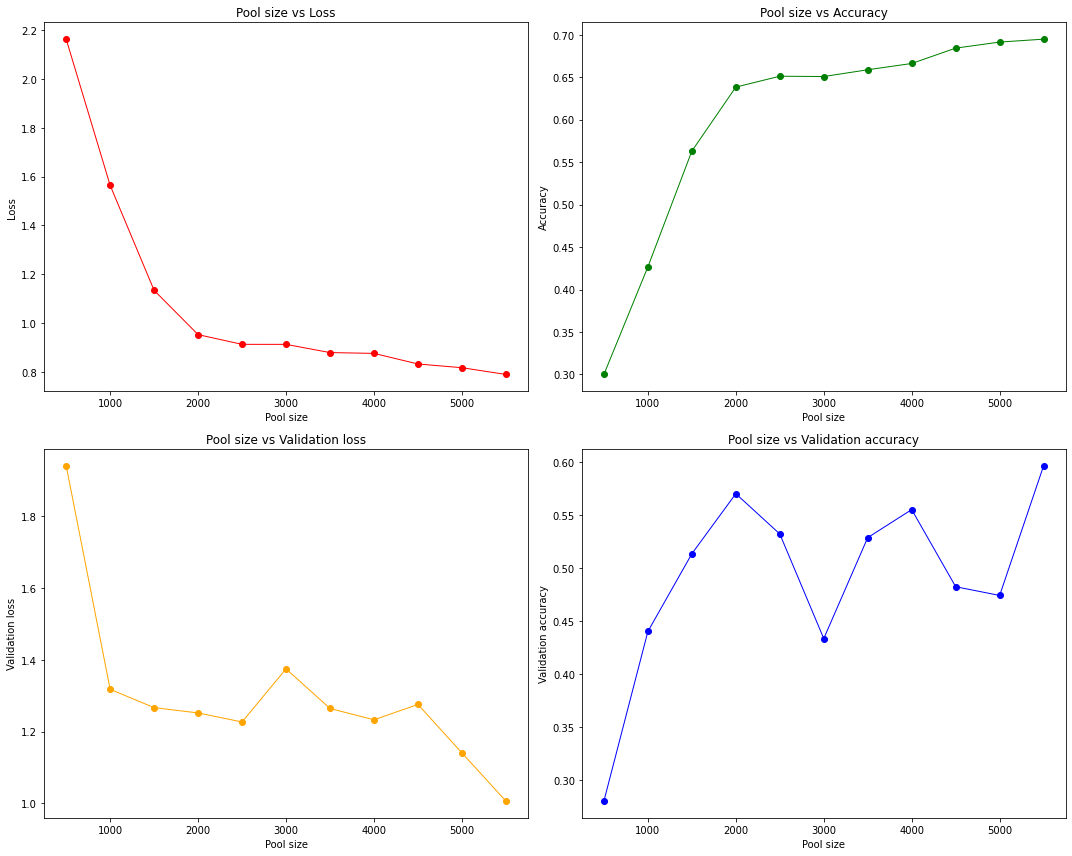

In [4]:
al_model_v1 = ActiveLearner()
al_model_v1.train(sampling=1)
al_model_v1.test()
al_model_v1.plot()

sample size = 500
Pool set: 500; Validation set: 59500
15/15 [==============================] - 1s 14ms/step - loss: 2.1804 - accuracy: 0.2378 - val_loss: 1.8713 - val_accuracy: 0.3400

Iteration 0
29/29 [==============================] - 0s 5ms/step - loss: 1.2276 - accuracy: 0.5878 - val_loss: 0.5861 - val_accuracy: 0.7100
Pool set: 1000; Validation set: 59000

Iteration 1
43/43 [==============================] - 0s 5ms/step - loss: 0.9458 - accuracy: 0.6459 - val_loss: 1.6584 - val_accuracy: 0.3067
Pool set: 1500; Validation set: 58500

Iteration 2
57/57 [==============================] - 0s 4ms/step - loss: 0.9476 - accuracy: 0.6378 - val_loss: 1.2807 - val_accuracy: 0.4950
Pool set: 2000; Validation set: 58000

Iteration 3
71/71 [==============================] - 0s 4ms/step - loss: 0.8637 - accuracy: 0.6671 - val_loss: 1.3829 - val_accuracy: 0.4920
Pool set: 2500; Validation set: 57500

Iteration 4
85/85 [==============================] - 0s 4ms/step - loss: 0.8337 - accuracy: 0.

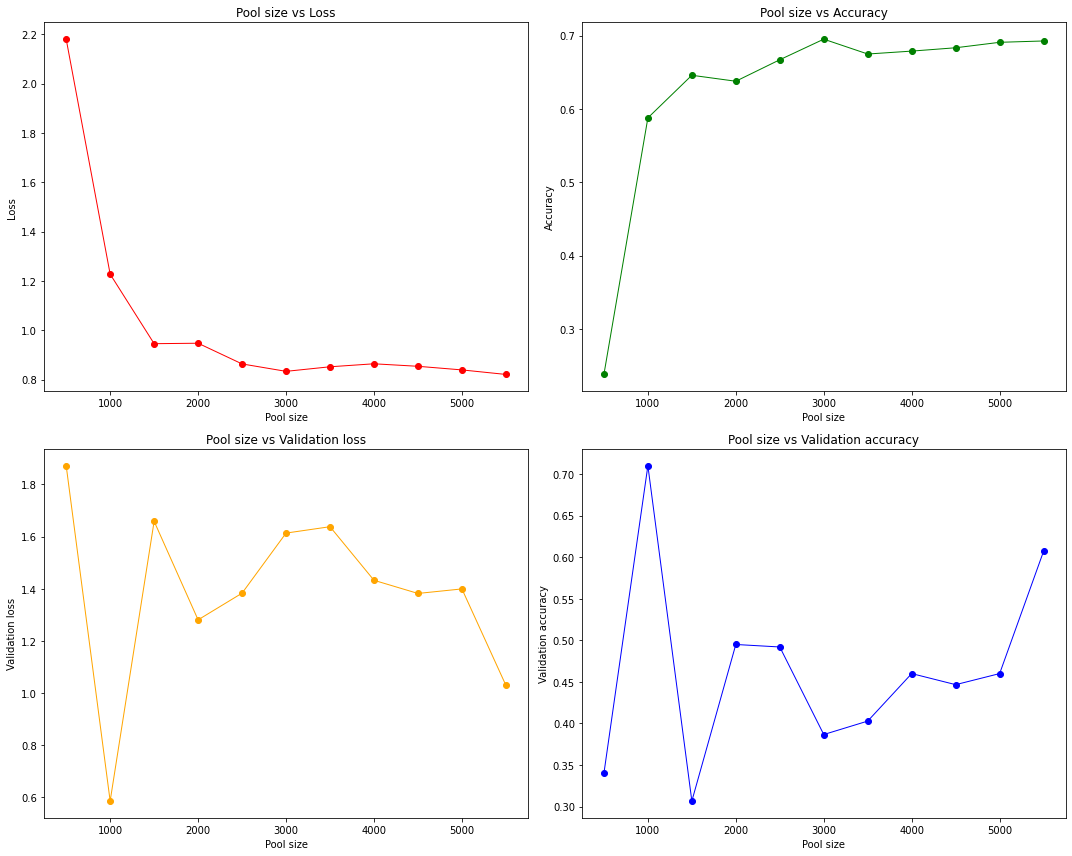

In [15]:
al_model_v2 = ActiveLearner()
al_model_v2.train(sampling=2)
al_model_v2.test()
al_model_v2.plot()

sample size = 500
Pool set: 500; Validation set: 59500
15/15 [==============================] - 1s 13ms/step - loss: 2.1493 - accuracy: 0.3067 - val_loss: 1.8818 - val_accuracy: 0.3400

Iteration 0
29/29 [==============================] - 0s 5ms/step - loss: 1.3690 - accuracy: 0.5200 - val_loss: 1.0914 - val_accuracy: 0.6200
Pool set: 1000; Validation set: 59000

Iteration 1
43/43 [==============================] - 0s 5ms/step - loss: 0.9131 - accuracy: 0.6637 - val_loss: 0.8111 - val_accuracy: 0.7200
Pool set: 1500; Validation set: 58500

Iteration 2
57/57 [==============================] - 0s 4ms/step - loss: 0.8152 - accuracy: 0.6906 - val_loss: 0.9412 - val_accuracy: 0.6250
Pool set: 2000; Validation set: 58000

Iteration 3
71/71 [==============================] - 0s 7ms/step - loss: 0.7593 - accuracy: 0.7058 - val_loss: 1.1517 - val_accuracy: 0.4920
Pool set: 2500; Validation set: 57500

Iteration 4
85/85 [==============================] - 0s 5ms/step - loss: 0.7440 - accuracy: 0.

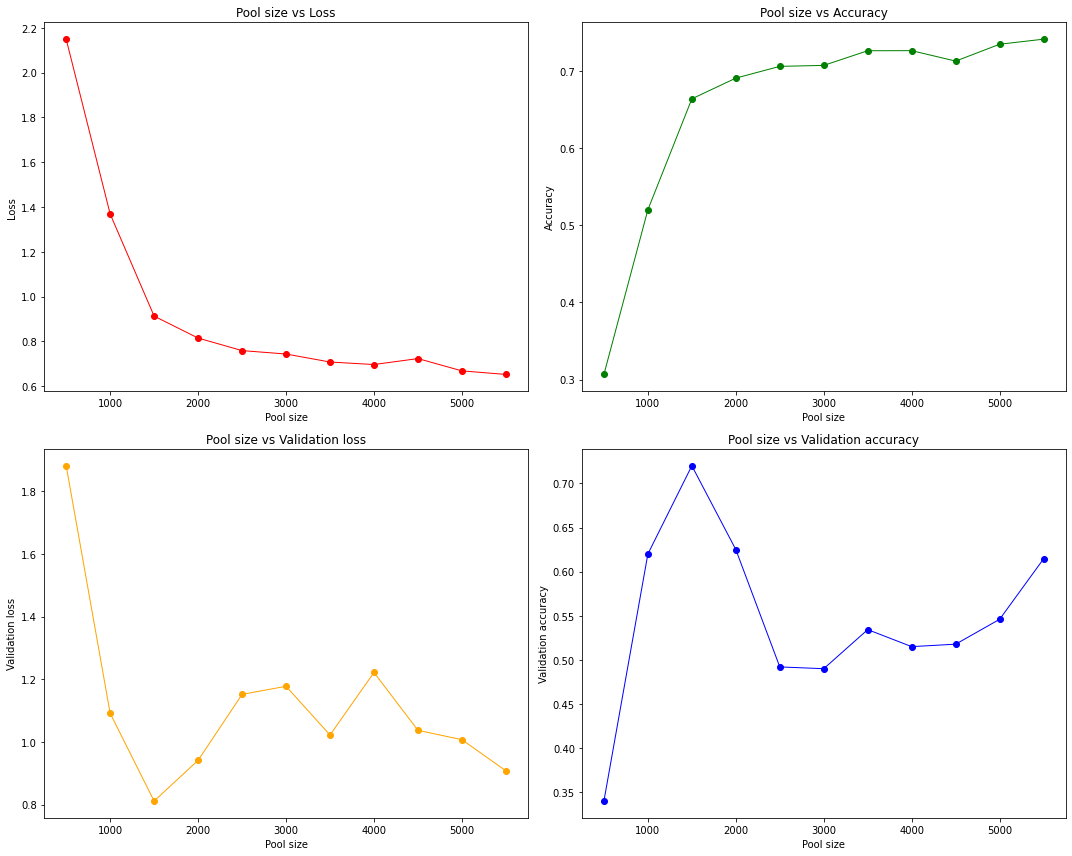

In [5]:
al_model_v3 = ActiveLearner()
al_model_v3.train(sampling=3)
al_model_v3.test()
al_model_v3.plot()

In [17]:
# comparison between baseline CNN and AL with uncertainty sampling
accuracy_ratio = (al_model_v1.test_acc / test_acc_baseline) * 100
loss_ratio = (al_model_v1.test_loss / test_loss_baseline) * 100
data_ratio = (al_model_v1.X_pool.shape[0] / X_train_baseline.shape[0]) * 100

print("Uncertainty sampling")
print(f"    Accuracy difference: {accuracy_ratio:.2f}%")
print(f"    Loss difference: {loss_ratio:.2f}%")
print(f"    Dataset size difference: {data_ratio:.2f}%")

Uncertainty sampling
    Accuracy difference: 93.83%
    Loss difference: 151.52%
    Dataset size difference: 9.17%


In [18]:
# comparison between baseline CNN and AL with entropy sampling
accuracy_ratio = (al_model_v2.test_acc / test_acc_baseline) * 100
loss_ratio = (al_model_v2.test_loss / test_loss_baseline) * 100
data_ratio = (al_model_v2.X_pool.shape[0] / X_train_baseline.shape[0]) * 100

print("Entropy sampling")
print(f"    Accuracy difference: {accuracy_ratio:.2f}%")
print(f"    Loss difference: {loss_ratio:.2f}%")
print(f"    Dataset size difference: {data_ratio:.2f}%")

Entropy sampling
    Accuracy difference: 90.11%
    Loss difference: 161.73%
    Dataset size difference: 9.17%


In [19]:
# comparison between baseline CNN and AL with margin sampling
accuracy_ratio = (al_model_v3.test_acc / test_acc_baseline) * 100
loss_ratio = (al_model_v3.test_loss / test_loss_baseline) * 100
data_ratio = (al_model_v3.X_pool.shape[0] / X_train_baseline.shape[0]) * 100

print("Margin sampling")
print(f"    Accuracy difference: {accuracy_ratio:.2f}%")
print(f"    Loss difference: {loss_ratio:.2f}%")
print(f"    Dataset size difference: {data_ratio:.2f}%")

Margin sampling
    Accuracy difference: 95.24%
    Loss difference: 135.20%
    Dataset size difference: 9.17%
